In [27]:
# from kan2 import * 不可解释
#暂时用这个 可解释
from kan import KAN
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
from sklearn.utils import shuffle
import random
import numpy as np
torch.set_default_dtype(torch.float32)

In [28]:
protein_feature_train = []

# 打开并读取文件
with open('/tmp/pycharm_project_763/feature/feature_train/phychem_train.txt', 'r') as file:
    # 逐行读取文件内容
    for line in file:
        if line.startswith('>'):  # 跳过以'>'开头的行（序列标识行）
            continue
        # 分割行中的每个特征并转换为浮点数
        features = [float(x) for x in line.strip().split('\t')]
        # 将特征列表添加到主列表中
        protein_feature_train.append(features)
# protein_feature_train[:5]   

In [29]:
protein_feature_test = []

# 打开并读取文件
with open('/tmp/pycharm_project_763/feature/feature_test/phychem_test.txt', 'r') as file:
    # 逐行读取文件内容
    for line in file:
        if line.startswith('>'):  # 跳过以'>'开头的行（序列标识行）
            continue
        # 分割行中的每个特征并转换为浮点数
        features = [float(x) for x in line.strip().split('\t')]
        # 将特征列表添加到主列表中
        protein_feature_test.append(features)

In [30]:
import pandas as pd
df = pd.read_csv('/tmp/pycharm_project_763/data/trainCPP.csv')

# 提取序列和标签
sequences = df['sequence'].tolist()
y = df['label'].tolist()

df2= pd.read_csv('/tmp/pycharm_project_763/data/testCPP.csv')

# 提取序列和标签
sequences_test = df2['sequence'].tolist()
y_test = df2['label'].tolist()

In [31]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(protein_feature_train, y, random_state=42)
X_test, y_test = shuffle(protein_feature_test, y_test, random_state=42)

In [32]:
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [33]:
X_train = torch.tensor(X_train,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test,dtype=torch.float32)
y_test = torch.tensor(y_test,dtype=torch.float32).view(-1, 1)

In [34]:
dataset={}
dataset = {
        'train_input': X_train,
        'test_input': X_test,
        'train_label': y_train,
        'test_label': y_test
    }

In [35]:
dataset['train_label'].shape,dataset['test_label'].shape

(torch.Size([1164, 1]), torch.Size([299, 1]))

In [36]:
dataset['test_label']

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
      

In [37]:
model = KAN(width=[24,5,1], grid=3, k=2, seed=42) 

checkpoint directory created: ./model
saving model version 0.0


In [38]:
from sklearn.metrics import roc_auc_score, confusion_matrix, matthews_corrcoef
def train_acc():
    pred=model(X_train)
    with torch.no_grad():
        pred_labels = (pred > 0.5).float() 
        auc = roc_auc_score(y_train.cpu(), pred.cpu())

    # 混淆矩阵计算
        tn, fp, fn, tp = confusion_matrix(y_train.cpu(), pred_labels.cpu()).ravel()

        # Specificity (SP)
        sp = tn / (tn + fp) if (tn + fp) > 0 else 0

        # Sensitivity (SN)
        sn = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Matthews Correlation Coefficient (MCC)
        mcc = matthews_corrcoef(y_train.cpu(), pred_labels.cpu())
    print(f"AUC: {auc:.4f}, SP: {sp:.4f}, MCC: {mcc:.4f}, SN: {sn:.4f}")
    return torch.mean((torch.round(model(X_train)[:, 0]) == y_train[:, 0]).float())

def test_acc():
    return torch.mean((torch.round(model(X_test)[:, 0]) == y_test[:, 0]).float())

# results = model.train(dataset, opt="LBFGS", steps=10, metrics=(train_acc, test_acc)) ,lamb=0.001 lamb_entropy=4.,lamb=0.1,lamb_l1=2.5,
# lamb=0.005 train/fit
results = model.fit(dataset, opt="LBFGS", steps=5, metrics=(train_acc, test_acc));
print(results['train_acc'][-1], results['test_acc'][-1])

| train_loss: 4.36e-01 | test_loss: 4.48e-01 | reg: 0.00e+00 | :  20%|▏| 1/5 [00:00<00:03,  1.18it/s

AUC: 0.7973, SP: 0.7663, MCC: 0.4269, SN: 0.6581


| train_loss: 4.05e-01 | test_loss: 4.34e-01 | reg: 0.00e+00 | :  40%|▍| 2/5 [00:01<00:01,  2.00it/s

AUC: 0.8453, SP: 0.7938, MCC: 0.4986, SN: 0.7027


| train_loss: 3.85e-01 | test_loss: 4.19e-01 | reg: 0.00e+00 | :  60%|▌| 3/5 [00:01<00:00,  2.58it/s

AUC: 0.8804, SP: 0.8608, MCC: 0.5692, SN: 0.7010


| train_loss: 3.71e-01 | test_loss: 4.12e-01 | reg: 0.00e+00 | :  80%|▊| 4/5 [00:01<00:00,  2.89it/s

AUC: 0.8985, SP: 0.8351, MCC: 0.6078, SN: 0.7715


| train_loss: 3.61e-01 | test_loss: 4.11e-01 | reg: 3.28e+01 | : 100%|█| 5/5 [00:02<00:00,  2.41it/s

AUC: 0.9092, SP: 0.8574, MCC: 0.6296, SN: 0.7698
saving model version 0.1
0.8135738968849182 0.7759197354316711


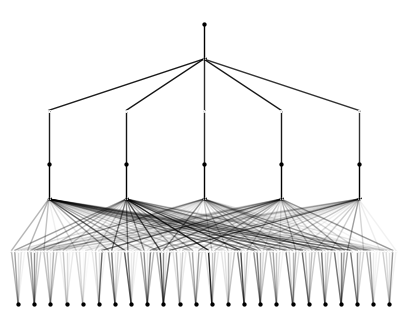

In [39]:
model.plot()

saving model version 0.2


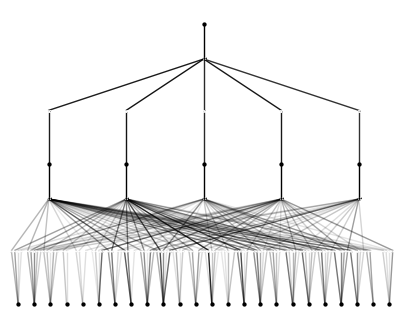

In [40]:
model=model.prune()
model.plot()

In [41]:
results =model.fit(dataset, opt="LBFGS", steps=5, metrics=(train_acc, test_acc));

| train_loss: 3.61e-01 | test_loss: 4.04e-01 | reg: 0.00e+00 | :  20%|▏| 1/5 [00:00<00:01,  2.47it/s

AUC: 0.9092, SP: 0.8385, MCC: 0.6229, SN: 0.7835


| train_loss: 3.47e-01 | test_loss: 3.98e-01 | reg: 0.00e+00 | :  40%|▍| 2/5 [00:00<00:01,  2.83it/s

AUC: 0.9241, SP: 0.8385, MCC: 0.7065, SN: 0.8677


| train_loss: 3.36e-01 | test_loss: 4.01e-01 | reg: 0.00e+00 | :  60%|▌| 3/5 [00:01<00:00,  2.89it/s

AUC: 0.9347, SP: 0.8694, MCC: 0.7492, SN: 0.8797


| train_loss: 3.27e-01 | test_loss: 4.02e-01 | reg: 0.00e+00 | :  80%|▊| 4/5 [00:01<00:00,  2.49it/s

AUC: 0.9417, SP: 0.8694, MCC: 0.7614, SN: 0.8918


| train_loss: 3.22e-01 | test_loss: 4.01e-01 | reg: 3.63e+01 | : 100%|█| 5/5 [00:02<00:00,  2.49it/s

AUC: 0.9453, SP: 0.8660, MCC: 0.7650, SN: 0.8986
saving model version 0.3


In [42]:
print(results['train_acc'][-1], results['test_acc'][-1])

0.880584180355072 0.8026756048202515


In [43]:
model = model.refine(10)

saving model version 0.4


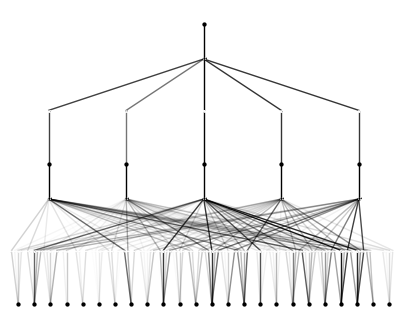

In [44]:
model.plot()

In [45]:
results =model.fit(dataset, opt="LBFGS", steps=5, metrics=(train_acc, test_acc));

| train_loss: 4.65e-01 | test_loss: 4.63e-01 | reg: 0.00e+00 | :  20%|▏| 1/5 [00:00<00:01,  2.43it/s

AUC: 0.7621, SP: 0.8265, MCC: 0.3852, SN: 0.5430


| train_loss: 4.13e-01 | test_loss: 4.32e-01 | reg: 0.00e+00 | :  40%|▍| 2/5 [00:00<00:01,  2.06it/s

AUC: 0.8325, SP: 0.8247, MCC: 0.4929, SN: 0.6615


| train_loss: 3.92e-01 | test_loss: 4.17e-01 | reg: 0.00e+00 | :  60%|▌| 3/5 [00:01<00:00,  2.07it/s

AUC: 0.8701, SP: 0.8144, MCC: 0.5949, SN: 0.7801


| train_loss: 3.78e-01 | test_loss: 4.07e-01 | reg: 0.00e+00 | :  80%|▊| 4/5 [00:01<00:00,  2.10it/s

AUC: 0.8877, SP: 0.8162, MCC: 0.6340, SN: 0.8179


| train_loss: 3.65e-01 | test_loss: 4.08e-01 | reg: 4.64e+01 | : 100%|█| 5/5 [00:02<00:00,  1.99it/s

AUC: 0.9080, SP: 0.8471, MCC: 0.6619, SN: 0.8144
saving model version 0.5


In [46]:
print(results['train_acc'][-1], results['test_acc'][-1])

0.8290377855300903 0.7725752592086792


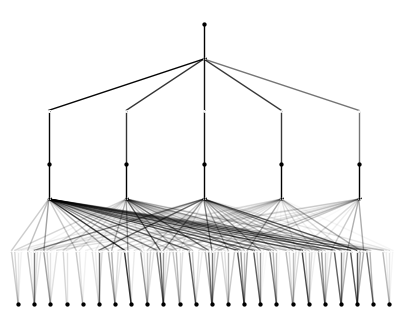

In [47]:
model.plot()

In [48]:
mode = "auto" # "manual"
"""
假设在一个神经网络模型中，坐标 (0,36,4) 可能表示：

层索引 (0): 第一层或第一个处理阶段。
单元索引 (36): 第一层中的第 37 个单元（因为索引从 0 开始）。
通道或特征索引 (4): 第 5 个通道或特征
"""

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.3970854580402374, c=1
fixing (0,0,1) with x, r2=0.7644026279449463, c=1
fixing (0,0,2) with x, r2=0.7860897779464722, c=1
fixing (0,0,3) with x, r2=0.8653388023376465, c=1
fixing (0,0,4) with 0
fixing (0,1,0) with x, r2=0.39390453696250916, c=1
fixing (0,1,1) with x, r2=0.37799033522605896, c=1
fixing (0,1,2) with x, r2=0.04384273663163185, c=1
fixing (0,1,3) with x, r2=0.5729665160179138, c=1
fixing (0,1,4) with sin, r2=0.9558371901512146, c=2
fixing (0,2,0) with x, r2=0.8480351567268372, c=1
fixing (0,2,1) with x, r2=0.7796861529350281, c=1
fixing (0,2,2) with x, r2=0.7972384691238403, c=1
fixing (0,2,3) with x, r2=0.385312020778656, c=1
fixing (0,2,4) with x, r2=0.6924183368682861, c=1
fixing (0,3,0) with 0
fixing (0,3,1) with x, r2=0.8344473838806152, c=1
fixing (0,3,2) with x, r2=0.6232271790504456, c=1
fixing (0,3,3) with 0
fixing (0,3,4) with 0
fixing (0,4,0) with x, r2=0.33982187509536743, c=1
fixing (0,4,1) with x, r2=0.7239445447921753, c=1
fixing 

In [49]:
from kan.utils import ex_round

ex_round(model.symbolic_formula()[0][0],4)

-0.0015*x_1 - 0.0007*x_10 - 0.0006*x_11 + 0.0001*x_12 - 0.0023*x_13 + 0.0008*x_14 - 0.004*x_16 + 0.0017*x_17 - 0.0001*x_18 + 0.0076*x_19 + 0.0019*x_2 + 0.0022*x_20 - 0.0039*x_21 + 0.0033*x_22 - 0.0039*x_23 + 0.003*x_24 + 0.0039*x_3 + 0.0017*x_5 - 0.0003*x_6 + 0.002*x_7 - 0.0062*x_8 - 0.0041*x_9 - 0.3177*exp(0.4595*x_1 - 0.7267*x_10 - 0.4507*x_12 - 2.0345*x_13 - 0.0602*x_14 + 0.7641*x_15 + 1.0098*x_17 + 0.1806*x_18 + 0.0867*x_2 - 0.675*x_20 + 0.4028*x_23 - 0.054*x_24 - 0.411*x_3 + 0.4612*x_4 - 0.2937*x_5 + 0.2052*x_6 - 0.4144*x_7 + 0.6103*x_8 + 0.1988*x_9 - 0.3709*(-0.9085*x_11 - 1)**2 + 1.1454*sin(0.655*x_16 - 0.754) - 0.3325*sin(2.5474*x_19 - 7.7962)) + 0.0108*sin(0.6243*x_15 + 5.6266) - 0.3044*sin(0.0845*x_10 + 0.1071*x_12 - 0.583*x_13 + 0.2423*x_14 + 0.0111*x_16 + 0.0971*x_19 + 0.2595*x_20 - 0.2865*x_22 + 0.2053*x_3 + 0.027*x_7 + 0.2703*x_9 - 0.1583*sin(2.6314*x_18 + 1.7769) - 0.1176*sin(4.0173*x_2 + 1.7982) + 2.1262*sin(0.354*x_21 + 2.1292) + 2.0547) - 2.1832*sin(-0.0491*x_1 + 0.09